# S&P500 Stock Price Prediction: Feature Selection

S&P500 consist of 500 largest companies listed on exchanges in the United States.
I will try to predict the future S&P500 stock price using: feature engineering and feature selection.

Work methods:
- Creation of new input features from existing features.
- Importing features of economic activity indicators with correlativity to the stock market from FRED.
- Filling sparse data using interpolation.
- Data transformation.

Target:
- Find the best features correlating with S&P500 stock price.
- Beat the benchmark model predictions accuracy.

## Import modules:

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import warnings
import time

warnings.filterwarnings("ignore")
randomness = 42

In [2]:
import matplotlib.pyplot as plt 
import plotly.graph_objects as go

from pandas_datareader import data as pdr
import yfinance as yfin
from fredapi import Fred
yfin.pdr_override()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso

## Import stock data:

In [3]:
# Read and prepare yahoo stock ticker info:
ticker = "SPY"
data = pdr.get_data_yahoo(ticker, start = dt.datetime(1990,1,1), end = dt.datetime.today())

ystock_data = data.copy()
ystock_data.index.names = ['date']
ystock_data.columns = ['open','high','low','close', 'adj_close','volume']

[*********************100%***********************]  1 of 1 completed


In [4]:
ystock_data[['high','low','adj_close','volume']].head(2)

,high,low,adj_close,volume
date,,,,
1993-01-29,43.96875,43.75000,25.438089,1003200
1993-02-01,44.25000,43.96875,25.619020,480500


In [5]:
ystock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7421 entries, 1993-01-29 to 2022-07-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       7421 non-null   float64
 1   high       7421 non-null   float64
 2   low        7421 non-null   float64
 3   close      7421 non-null   float64
 4   adj_close  7421 non-null   float64
 5   volume     7421 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 405.8 KB


## Import supplemental economic data:

In [7]:
# fred ticker and ticker-name dictionery for economic activity indicators:
columns_dic = {
    "unemployment_claims": "ICSA",
    "consumer_goods_orders": "ACOGNO",
    "capital_goods_orders": "ANDENO",
    "new_housing_permits": "PERMIT",
    "money_supply": "WM2NS",
    "interest_rate": "T10YFF",
    "consumer_sentiment": "UMCSENT",
    "delivery_time": "DTCDFNA066MNFRBPHI",
    "crude_birth_rate": "SPDYNCBRTINUSA",
    "net_migration": "SMPOPNETMUSA",
    "energy_price": "PNRGINDEXM",
    "gini": "SIPOVGINIUSA",
    "usa_pop": "POPTOTUSA647NWDB",
    "pop_growth": "SPPOPGROWUSA",
    "dependency_ratio": "SPPOPDPNDOLUSA",
    "world_pop": "SPPOPTOTLWLD",
}

In [8]:
# fill gaps in fred data using interpolation:
def day_fill_smooth(df):
    start_date = df.index.min() - pd.DateOffset(day=1)
    dates = pd.date_range(start_date, df.index.max(), freq='D')
    dates.name = 'date'
    df2 = df.reindex(dates)
    days_apart = round(len(df2)/len(df))
    
    if days_apart > 30:
        return df2.interpolate(method='quadratic')
    else:
        return df2.interpolate(method='time')

# Get and fill data from fred:
def get_fred(dic):
    full_data = {}
    filled_data = {}
    for i in dic:
        full_data[i] = fred.get_series(dic[i],timeout=20)
        filled_data[i] = day_fill_smooth(full_data[i])
        
    return pd.DataFrame(filled_data), pd.DataFrame(full_data)

In [9]:
%%time
EAindicators, fred_source = get_fred(columns_dic)

CPU times: total: 3.09 s
Wall time: 15.4 s


### Study supplemental data:

In [10]:
EAindicators.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26497 entries, 1950-01-01 to 2022-07-18
Freq: D
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   unemployment_claims    20273 non-null  float64
 1   consumer_goods_orders  11048 non-null  float64
 2   capital_goods_orders   11048 non-null  float64
 3   new_housing_permits    22798 non-null  float64
 4   money_supply           15191 non-null  float64
 5   interest_rate          22113 non-null  float64
 6   consumer_sentiment     25384 non-null  float64
 7   delivery_time          19755 non-null  float64
 8   crude_birth_rate       21916 non-null  float64
 9   net_migration          20090 non-null  float64
 10  energy_price           11049 non-null  float64
 11  gini                   16437 non-null  float64
 12  usa_pop                22282 non-null  float64
 13  pop_growth             21916 non-null  float64
 14  dependency_ratio       22282 

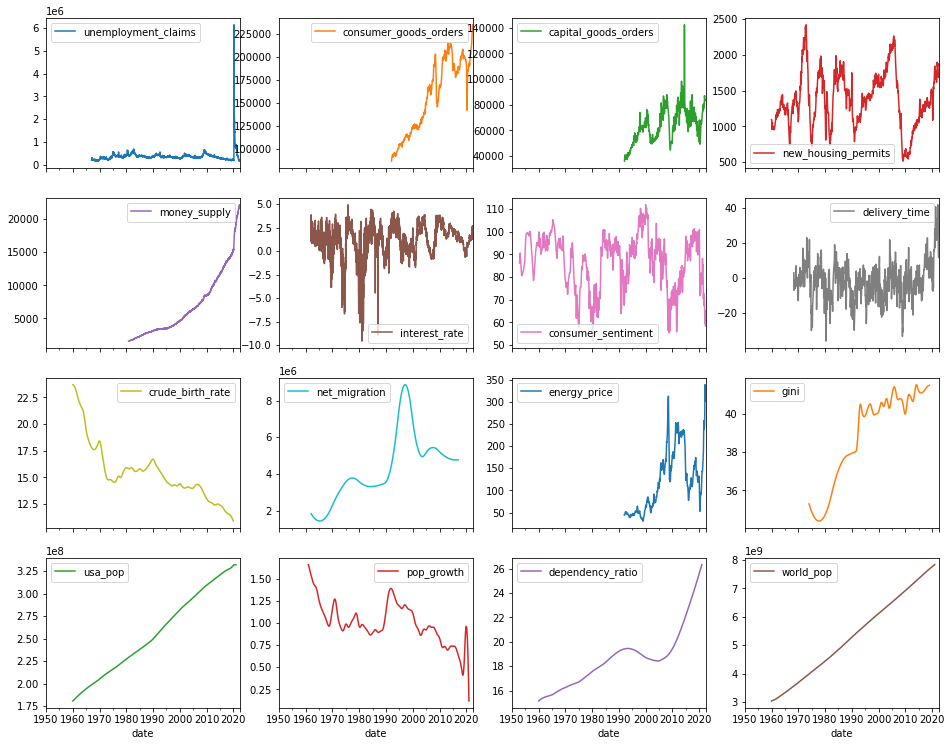

In [13]:
EAindicators.plot(subplots=True, layout=(5,4), figsize=(16,16));

## Combine and create new features:

In [14]:
def RSI(data, n):
    # relative strength index
    up_df, down_df = data['change'].copy(), data['change'].copy()

    up_df.loc[up_df<0] = 0
    down_df.loc[down_df>0] = 0
    down_df = down_df.abs()

    ewma_up = up_df.transform(lambda x: x.ewm(span = n).mean())
    ewma_down = down_df.transform(lambda x: x.ewm(span = n).mean())
    relative_strength = ewma_up / ewma_down

    relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))
    return relative_strength_index

In [16]:
#  create new features
def make_features(data, max_lag=0, SHORT=5, MEDIUM=20, LONG=120):

    data["year"] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    if max_lag != 0:
        for lag in range(1, max_lag + 1):
            data['lag_{}'.format(lag)] = data['adj_close'].shift(lag)

    data['change'] = data['adj_close'].diff()
    data['change_rate'] = data['adj_close'].pct_change(periods = MEDIUM)
    data['change_rate'][data['change_rate'] == np.inf] = 1
    data['change_rate'][data['change_rate'] == -np.inf] = -1
        
    data['rolling_{}'.format(SHORT)] = data['adj_close'].ewm(SHORT).mean()
    data['rolling_{}'.format(MEDIUM)] = data['adj_close'].ewm(MEDIUM).mean()
    data['rolling_{}'.format(LONG)] = data['adj_close'].ewm(LONG).mean()

    data['rolling_{}H'.format(SHORT)] = data['adj_close'].rolling(SHORT).max()
    data['rolling_{}L'.format(SHORT)] = data['adj_close'].rolling(SHORT).min()
    data['rolling_{}HH'.format(SHORT)] = data['high'].rolling(SHORT).max()
    data['rolling_{}LL'.format(SHORT)] = data['low'].rolling(SHORT).min()
    
    data['rolling_{}H'.format(MEDIUM)] = data['adj_close'].rolling(MEDIUM).max()
    data['rolling_{}L'.format(MEDIUM)] = data['adj_close'].rolling(MEDIUM).min()
    data['rolling_{}HH'.format(MEDIUM)] = data['high'].rolling(MEDIUM).max()
    data['rolling_{}LL'.format(MEDIUM)] = data['low'].rolling(MEDIUM).min()
    
    data['rolling_{}H'.format(LONG)] = data['adj_close'].rolling(LONG).max()
    data['rolling_{}L'.format(LONG)] = data['adj_close'].rolling(LONG).min()
    data['rolling_{}HH'.format(LONG)] = data['high'].rolling(LONG).max()
    data['rolling_{}LL'.format(LONG)] = data['low'].rolling(LONG).min()
    
    data['k_percent'] = 100 * ((data['adj_close'] - data['rolling_{}LL'.format(SHORT)]) / (data['rolling_{}HH'.format(SHORT)] - data['rolling_{}LL'.format(SHORT)]))
    data['momentum'] = 100*((data['adj_close'] - data['rolling_{}L'.format(SHORT)]) / (data['rolling_{}H'.format(SHORT)] - data['rolling_{}L'.format(SHORT)]))
    data['r_percent'] = ((data['rolling_{}H'.format(SHORT)] - data['adj_close']) / (data['rolling_{}H'.format(SHORT)] - data['rolling_{}L'.format(SHORT)])) * - 100
    
    data['macd'] = data['rolling_{}'.format(SHORT)] - data['rolling_{}'.format(MEDIUM)]
    data['macd_ema'] = data['macd'].ewm(5).mean()
    data['rsi'] = RSI(data,SHORT)
    
    return data

### Check partial autocorrelation for 'adj_close':

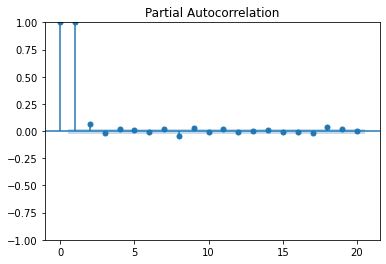

In [17]:
import statsmodels.api as sm
sm.graphics.tsa.plot_pacf(ystock_data.adj_close,lags = 20);

* Only one previous day is significant.


### Create dataframe with prediction target:

In [51]:
# Create adj_target to predict:
days_to_predict = 5

EAindicators2 = pd.concat([EAindicators,ystock_data[['high','low','adj_close','volume']]], axis=1).dropna()
EAindicators2['adj_target'] = EAindicators2.adj_close.shift(-days_to_predict)
data_e = EAindicators2.copy().dropna()
data_model = make_features(data_e)
data_model.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6021 entries, 1993-01-29 to 2016-12-22
Data columns (total 48 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   unemployment_claims    6021 non-null   float64
 1   consumer_goods_orders  6021 non-null   float64
 2   capital_goods_orders   6021 non-null   float64
 3   new_housing_permits    6021 non-null   float64
 4   money_supply           6021 non-null   float64
 5   interest_rate          6021 non-null   float64
 6   consumer_sentiment     6021 non-null   float64
 7   delivery_time          6021 non-null   float64
 8   crude_birth_rate       6021 non-null   float64
 9   net_migration          6021 non-null   float64
 10  energy_price           6021 non-null   float64
 11  gini                   6021 non-null   float64
 12  usa_pop                6021 non-null   float64
 13  pop_growth             6021 non-null   float64
 14  dependency_ratio       6021 non-null  

* Created 43 new features overall.

## Compare different models:

In [52]:
def calculate_mape(y_true, y_pred): 
    y_pred, y_true = np.array(y_pred), np.array(y_true)    
    mape = np.mean(np.abs((y_true-y_pred) / y_true))*100    
    return mape

In [53]:
def model_evaluation( model ,features_train,target_train,features_test,target_test):
    t0= time.time()
    
    model.fit(features_train, target_train)
    t1= time.time()

    predictions2 = model.predict(features_test)
    t2= time.time()
    
    predictions1 = model.predict(features_train)

    RMSE1 = mean_squared_error(target_train, predictions1)**0.5
    RMSE2 = mean_squared_error(target_test, predictions2)**0.5
    MAPE = calculate_mape(target_test, predictions2)
    
    score= {'training_rmse': [RMSE1],
            'test_rmse': [RMSE2],
            'test_mape': [MAPE],
            'training_time': [t1 - t0],
            'prediction_time': [t2 - t1] ,
            'total_time': [t2 - t0]
           }  

    return pd.DataFrame(score)

In [54]:
def model_comparison(data):
    
    train, test = train_test_split(data.dropna(), shuffle=False, test_size=0.2)
    target_train = train['adj_target']
    features_train = train.drop('adj_target', axis=1)
    target_test = test['adj_target']
    features_test = test.drop('adj_target', axis=1)
    
    model_score_ev =  pd.DataFrame()
    list_of_models = [LinearRegression(),
                      Lasso(alpha=0.05, random_state=randomness),
                      Ridge(), 
                      ElasticNet(random_state=randomness)]

    for mod in list_of_models:
        model_score_ev = model_score_ev.append(model_evaluation(mod,
                                                               features_train,
                                                                target_train,
                                                                features_test,
                                                                target_test))
    
    model_score_ev.index = ['LinearRegression','Lasso','Ridge','ElasticNet']

    return model_score_ev[['training_rmse','test_rmse','test_mape']].sort_values(by = "test_mape")

In [55]:
%%time
model_comparison(data_model)

CPU times: total: 1.92 s
Wall time: 505 ms


,training_rmse,test_rmse,test_mape
Ridge,1.840750,7.548515,3.811959
ElasticNet,1.941877,11.385922,5.633032
LinearRegression,1.835453,10.956327,5.651519
Lasso,1.902195,11.483347,5.779244


## Manual feature tuning:

In [56]:
def log_transform(data):
    return (np.log(data+1))

def standardization(data):
    return (data-data.mean())/data.std()

def normalize(data):
    return ((data-data.mean())/(data.max() - data.min())) +0.5

def transformer(data , trans, namelist):
    for name in namelist:
        data[name] = trans(data[name])
    return data

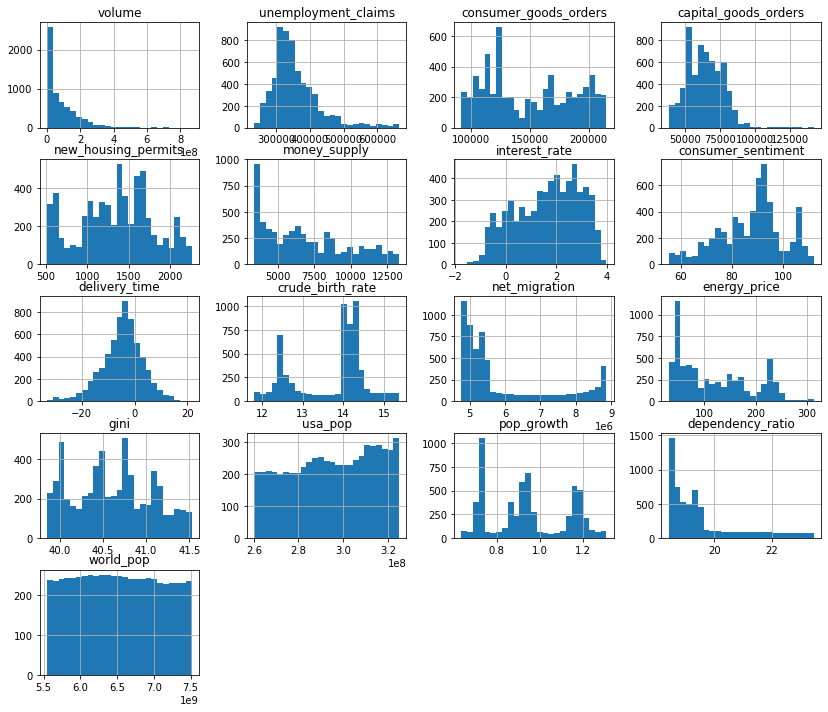

In [57]:
data_model[EAindicators.columns.insert(0,'volume')].hist( figsize=(14,12),bins = 25);

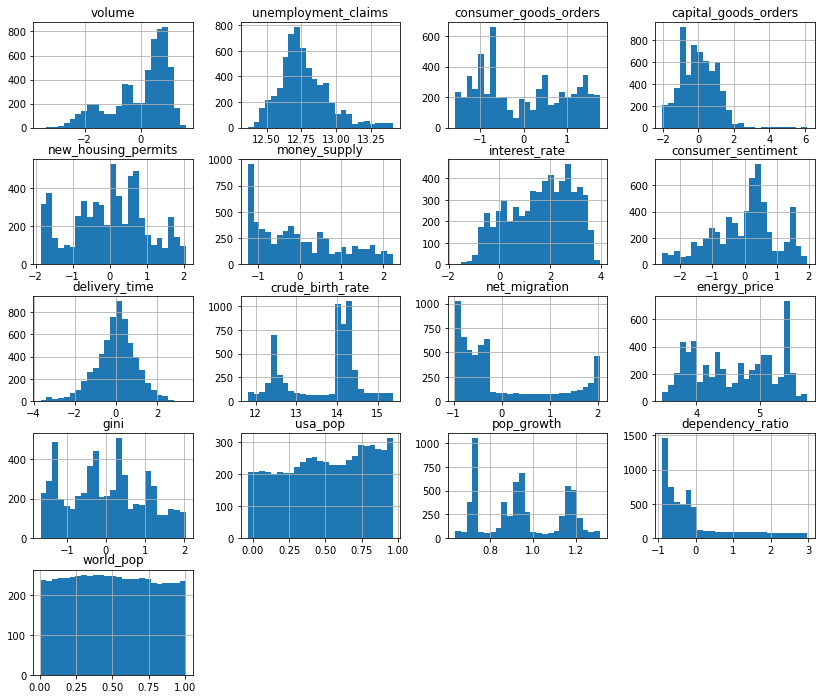

In [58]:
trans_dt = data_model.copy()

list1 = ['unemployment_claims',
         'net_migration',
         'energy_price',
         'volume',
        ]

list2 = ['volume',
         'net_migration',
         'consumer_goods_orders',
         'capital_goods_orders',
         'new_housing_permits',
         'money_supply',
         'consumer_sentiment',
         'gini',
         'dependency_ratio',
         'delivery_time',
         'usa_pop',
         'world_pop',
        ]

list3 = ['usa_pop',
         'world_pop',
        ]
   
trans_dt = transformer(trans_dt , log_transform , list1)
trans_dt = transformer(trans_dt , standardization , list2)
trans_dt = transformer(trans_dt , normalize , list3)

trans_dt[EAindicators.columns.insert(0,'volume')].hist( figsize=(14,12),bins = 25);

## Automated feature selection:

In [59]:
from mlxtend.feature_selection import SequentialFeatureSelector

train, test = train_test_split(trans_dt.dropna(), shuffle=False, test_size=0.2)
target_train = train['adj_target']
features_train = train.drop('adj_target', axis=1)

scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)

In [86]:
%%time
auto_mape = []
minrange =  5
maxrange =  len(trans_dt.columns)-10

for i in range(minrange, maxrange):
    results = []
    sfs = SequentialFeatureSelector(LinearRegression(), forward=False, k_features=i)
    sfs.fit(features_train_scaled, target_train)
    reslt = model_comparison(trans_dt[features_train.columns[np.array(sfs.k_feature_idx_)].insert(0,'adj_target')]).test_mape[0]
    results.append(i)
    results.append(reslt)
    auto_mape.append(results)

auto_mape = pd.DataFrame(auto_mape,columns=['n_features','test_mape'])
best_fn = auto_mape.n_features[auto_mape.test_mape.idxmin()]
print("Best number of features is:", best_fn )

Best number of features is: 9
CPU times: total: 1h 37min 29s
Wall time: 26min 8s


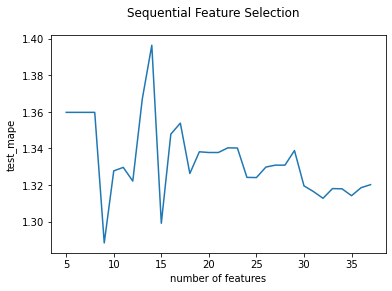

In [87]:
plt.plot(auto_mape.n_features, auto_mape.test_mape)
plt.suptitle('Sequential Feature Selection')
plt.xlabel('number of features')
plt.ylabel('test_mape')
plt.show()

In [92]:
sfs = SequentialFeatureSelector(LinearRegression(), forward=False, k_features= int(best_fn) )
sfs.fit(features_train_scaled, target_train)

cols_dropped = [col for col in features_train.columns if col not in features_train.columns[np.array(sfs.k_feature_idx_)]]
best_col = features_train.columns[np.array(sfs.k_feature_idx_)]

print("Features dropped: ", len(cols_dropped),"\n", cols_dropped)
print("\nSelected features: ", len(best_col),"\n", best_col.values)

Features dropped:  38 
 ['unemployment_claims', 'consumer_goods_orders', 'capital_goods_orders', 'money_supply', 'delivery_time', 'crude_birth_rate', 'energy_price', 'gini', 'high', 'low', 'volume', 'year', 'month', 'day', 'dayofweek', 'change', 'change_rate', 'rolling_5', 'rolling_20', 'rolling_120', 'rolling_5H', 'rolling_5L', 'rolling_5HH', 'rolling_5LL', 'rolling_20H', 'rolling_20L', 'rolling_20HH', 'rolling_20LL', 'rolling_120H', 'rolling_120L', 'rolling_120HH', 'rolling_120LL', 'k_percent', 'momentum', 'r_percent', 'macd', 'macd_ema', 'rsi']

Selected features:  9 
 ['new_housing_permits' 'interest_rate' 'consumer_sentiment'
 'net_migration' 'usa_pop' 'pop_growth' 'dependency_ratio' 'world_pop'
 'adj_close']


## Sanity check:
- Comparing model accuracy vs. benchmark model using single feature ( 'adj_target' ) in a range of prediction distances.

In [93]:
sanity_results = []

for i in [ 1,2,3,4,5,10,15,20,30,40,50,60,80,100 ]:
    results = []
    f_data = trans_dt.copy()
    f_data['adj_target'] = f_data.adj_close.shift(-i)
    f_data.dropna()
    
    results.append(i)
    results.append(model_comparison(f_data[['adj_close','adj_target']]).test_mape[0])
    results.append(model_comparison(f_data[best_col.insert(0,'adj_target')]).test_mape[0])
    sanity_results.append(results)

sanity_results = pd.DataFrame(sanity_results,columns=['days','sanity_mape','prediction_mape'])

In [95]:
sanity_results

,days,sanity_mape,prediction_mape
0,1,0.598420,0.597185
1,2,0.852795,0.838570
2,3,1.061015,1.028972
3,4,1.234575,1.189878
4,5,1.366447,1.296595
5,10,1.861286,1.754128
6,15,2.296618,2.097756
7,20,2.683342,2.369351
8,30,3.425078,2.853399
9,40,3.993710,3.114299


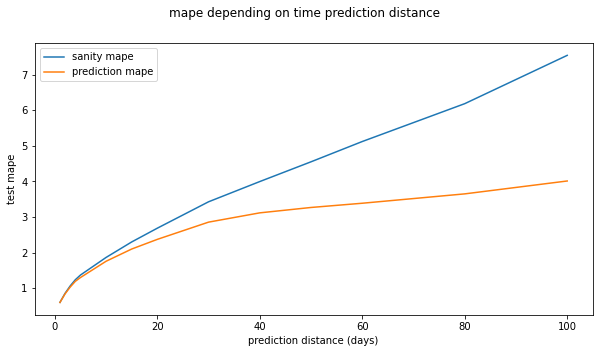

In [94]:
plt.figure(figsize=(10,5))
plt.plot(sanity_results.days, sanity_results[['sanity_mape','prediction_mape']])
plt.suptitle('mape depending on time prediction distance')
plt.xlabel('prediction distance (days)')
plt.ylabel('test mape')
plt.legend(['sanity mape','prediction mape'])
plt.show()

## Summary and Conclusions:
* Timeframe: '1993-01-29' until '2016-12-29'.
* 27 features created, non of them selected for the final model.
* 16 features imported, 8 of them selected for the final model.
* The model features were selected to optimise prediction 5 days in the future.
* If we will choose other timeframe to predict other features will be selected.
* The difference between the sanity and model mape is increasing with the prediction distance.